# Storm Selection
The aim is to use results from my load-balancing control algorithm (https://github.com/stroutm/LBCsewer) as inputs to the WRRF primary system model. The load-balancing control algorithm determines releases from distributed sewer storage assets to achieve near steady-state conditions (both in flow and total suspended solids load) at the WRRF influent. This notebook separates individual storm events from these result time series based on provided time indices.

Indices in the loaded results have a sampling frequency of 10 seconds.

### stormNo

**Storm event 1:** Days 1-10; Indices 8,640-86,400

**Storm event 2:** Days 35-53; Indices 302,400-457,920

**Storm event 3:** Days 28-37; Indices 241,920-319,680

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set as 0 if using results from no control simulation
# Set as 1 if using results from control, flow/TSS load simulation
# Set as 2 if using results from control, flow simulation
# Set as 3 if using results from control, TSS load simulation
controlled = 1

stormNo = '1'

controlNo = '01'

In [3]:
# Name storm event
if controlled == 0:
    storm_name = './data/storm'+stormNo+'.npy'
elif controlled == 1:
    # Simultaneous flow/TSS load control
    storm_name = './data/storm'+stormNo+'_control_both_'+controlNo+'.npy'
elif controlled == 2:
    # Flow control
    storm_name = './data/storm'+stormNo+'_control_flow_'+controlNo+'.npy'
elif controlled == 3:
    # TSS load control
    storm_name = './data/storm'+stormNo+'_control_TSS_'+controlNo+'.npy'

# Start and end indices for the storm event
day_start = 1
day_end = 10
ind_start = day_start * 24 * 60 * 60 / 10
ind_end = day_end * 24 * 60 * 60 / 10

In [4]:
# Load uncontrolled results
# Arguments needed for converting from Python 2-created .npy to Python 3-loading
if controlled == 0:
    data = np.load('./data/LBCresults/test_both_final_short.npy', allow_pickle=True, encoding='latin1')
elif controlled == 1:
    data = np.load('./data/LBCresults/test_both_final_short_01.npy', allow_pickle=True, encoding='latin1')
elif controlled == 2:
    data = np.load('./data/LBCresults/test_flow_final_short_'+controlNo+'.npy', allow_pickle=True, encoding='latin1')
elif controlled == 3:
    data = np.load('./data/LBCresults/test_TSS_final_short_'+controlNo+'.npy', allow_pickle=True, encoding='latin1')

# Pull states that are of interest:
#### Flow and TSS load at the WRRF influent; simulation time
if controlled == 0:
    t = data.item().get('time')
else:
    t = data.item().get('time_state')

WRRF_flow = data.item().get('WRRF_flow')
WRRF_TSSLoad = data.item().get('WRRF_TSSLoad')

In [5]:
# Trim to storm of interest
t_int = t[int(ind_start):int(ind_end)]
WRRF_flow_int = WRRF_flow[int(ind_start):int(ind_end)]
WRRF_TSSLoad_int = WRRF_TSSLoad[int(ind_start):int(ind_end)]

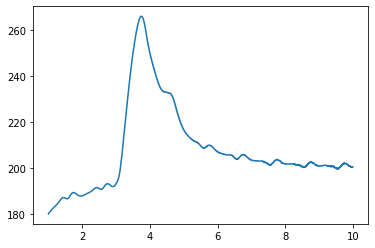

In [6]:
# Plot to see section
plt.plot(t_int,WRRF_flow_int)

In [7]:
# Choose indices of one dry-weather day

# Storm 1: 1
# Storm 2: 
# Storm 3: 36
day_start_dw = 1
day_end_dw = day_start_dw + 1
ind_start_dw = int(day_start_dw * 24 * 60 * 60 / 10)
ind_end_dw = int(day_end_dw * 24 * 60 * 60 / 10)

In [8]:
# Isolate dry-weather flow and TSS load
dw_flow_day = WRRF_flow[ind_start_dw:ind_end_dw]
dw_TSSLoad_day = WRRF_TSSLoad[ind_start_dw:ind_end_dw]

# Repeat dry-weather pattern for length of storm selection period
dw_flow = []
dw_TSSLoad = []

for _ in range(0, day_end-day_start):
    dw_flow = np.append(dw_flow, dw_flow_day)
    dw_TSSLoad = np.append(dw_TSSLoad, dw_TSSLoad_day)

In [9]:
# Get wet-weather flow and TSS load
ww_flow = np.zeros_like(dw_flow)
ww_TSSLoad = np.zeros_like(dw_TSSLoad)

for i in range(0,len(dw_flow)):
    ww_flow[i] = WRRF_flow_int[i] - dw_flow[i]
    ww_TSSLoad[i] = WRRF_TSSLoad_int[i] - dw_TSSLoad[i]

152.41794813986212


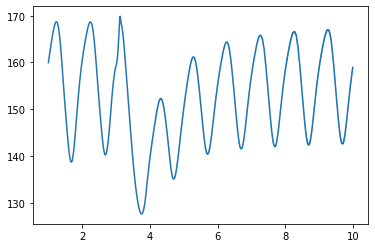

In [10]:
# Get TSS concentration (in units of mg/L) from TSS load and flow
WRRF_TSSConc = np.divide(WRRF_TSSLoad_int,WRRF_flow_int) / 2.205 * (10**6) / 28.32

print(np.mean(WRRF_TSSConc))
plt.plot(t_int,WRRF_TSSConc)

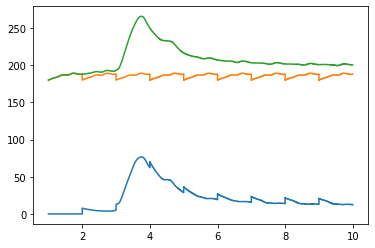

In [11]:
# Plot to double check for flow
plt.plot(t_int,ww_flow)
plt.plot(t_int,dw_flow)
plt.plot(t_int,WRRF_flow_int)

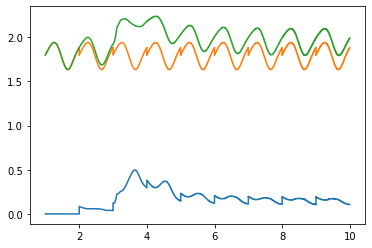

In [12]:
# Plot to double check for TSS load
plt.plot(t_int,ww_TSSLoad)
plt.plot(t_int,dw_TSSLoad)
plt.plot(t_int,WRRF_TSSLoad_int)

In [13]:
storm = {'time': t_int,
        'WRRF_flow': WRRF_flow_int,
        'WRRF_TSSLoad': WRRF_TSSLoad_int,
        'WRRF_TSSConc': WRRF_TSSConc,
        'WRRF_flow_dry': dw_flow,
        'WRRF_TSSLoad_dry': dw_TSSLoad,
        'WRRF_flow_wet': ww_flow,
        'WRRF_TSSLoad_wet': ww_TSSLoad}
np.save(storm_name,storm)